In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import datetime
import seaborn as sns
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows',3000)
pd.set_option('display.max_columns',200)
pd.set_option('display.max_info_columns',200)

In [1]:
def count_errtype(x):
    count=0
    
    for col in x[1:]:
        if col>0:
            count+=1
    return count

def fwver_clear(x):
    if x in train_test_fwver:
        return x
    else :
        return '0'
    
def is_update(x):
    update = x['fw_0':].sum()
    if update >=2:
        return 1
    else: 
        return 0
    
def fw_cnt(x):
    update = x['fw_0':'fw_8.5.3'].sum()
    return update

def errcode_prep(x):
    x = str(x)
    if x in top_errcode:
        return x
    else: 
        return 'user_errcode'
    
def count_errcode(x):
    count=0
    
    for col in x[1:]:
        if col>0:
            count+=1
    return count

def make_hour(x):
    x = str(x)
    hour = int(x[8:10])
    return hour

In [3]:
#feature
train_err = pd.read_csv('./data/train_err_data.csv', encoding = 'euc-kr')
train_quality = pd.read_csv('./data/train_quality_data.csv', encoding = 'euc-kr')
#target
train_problem = pd.read_csv('./data/train_problem_data.csv', encoding = 'euc-kr')

#feature
test_err = pd.read_csv('./data/test_err_data.csv', encoding = 'euc-kr')
test_quality = pd.read_csv('./data/test_quality_data.csv', encoding = 'euc-kr')
#target
sample_submission = pd.read_csv('./data/sample_submission.csv', encoding = 'euc-kr')

In [4]:
err_df = pd.concat([train_err,test_err],axis=0)
#계속 데이터 이어붙일 concat_err_df 생성
user_id=err_df.user_id.unique()
concat_err_df = pd.DataFrame({'user_id':user_id})

# model_nm 전처리

In [5]:
#model_nm 원핫인코딩 해서 user_id붙여줌.
user_id = err_df.user_id.values
err_df_model_nm=pd.get_dummies(err_df['model_nm'])
err_df_model_nm.insert(0,'user_id',user_id)

In [6]:
#user_id를 기준으로 groupby한 후 aggregation mean실행.
err_df_groupby_model=err_df_model_nm.groupby('user_id').agg('sum')

for col in err_df_groupby_model.columns:
    err_df_groupby_model[col] = err_df_groupby_model[col].apply(lambda x : 1 if x>0 else 0)

err_df_groupby_model['model_sum'] = err_df_groupby_model.sum(axis=1)
#index로 user_id가 들어가있어서 reset시킴
err_df_groupby_model.reset_index(inplace=True)
#concat_err_df에 merge시킴.
concat_err_df =concat_err_df.merge(err_df_groupby_model,how='left',on='user_id')
#다 쓴 메모리 반환
# del err_df_model_nm, err_df_groupby_model

# errtype 전처리

In [7]:
#혹시나 errtype안에 object말고 다른게 들어있을까봐.
err_df['errtype'].astype(str)
errtype_onehot=pd.get_dummies(err_df['errtype'])
errtype_cols=errtype_onehot.columns

#컬럼명 변경
new_cols = []
for col in errtype_cols:
    new_cols.append("et_"+str(col))
errtype_onehot.columns = new_cols
errtype_onehot.insert(loc =0, column = 'user_id', value = err_df.user_id.values)

#user_id 로 groupby하고
errtype_onehot_groupby_sum=errtype_onehot.groupby('user_id').agg(sum)

#한 유저에게서 error가 몇번났는지 sum값도 추가.
errtype_onehot_groupby_sum['errlog_sum'] = errtype_onehot_groupby_sum.sum(axis =1)

errtype_onehot_groupby_sum['errtype_count'] = errtype_onehot_groupby_sum.apply(lambda x : count_errtype(x),axis=1)

In [8]:
#데이터 분포가 정규분포를 안따라서 log화 시킴
#errtype_onehot_groupby_sum=errtype_onehot_groupby_sum.apply(np.log1p)

#인덱스를 column으로 반환
errtype_onehot_groupby_sum.reset_index(inplace=True)

#train과 test를 합쳐서 preprocessing진행
concat_err_df = concat_err_df.merge(errtype_onehot_groupby_sum,how='left',on='user_id')

# fwver 전처리

In [9]:
fw_prep = err_df.copy()
#train, test겹치는 fwver을 찾고
train_test_fwver = (set(train_err.fwver.unique()) & set(test_err.fwver.unique()))


#겹치는 fwver에 대해서는 그대로 두고 아니면 '0'으로 바꿈.
fw_prep['fwver'] = fw_prep['fwver'].apply(fwver_clear)

#fwver 원핫인코딩하고
fwver_onehot=pd.get_dummies(fw_prep['fwver'])

fwver_onehot.insert(loc =0, column = 'user_id', value = err_df.user_id.values)

#user_id로 groupby해서 agg(sum)하는데. sum안하고 1, 0으로 표기 안되는지..
fwver_onehot = fwver_onehot.groupby('user_id').agg('sum')
# for col in fwver_onehot.columns:
#     fwver_onehot[col] = fwver_onehot[col].apply(lambda x : 1 if x>0 else 0)
    
fwver_onehot.reset_index(inplace = True)

#알아보기 편하게 컬럼명 변경
cols = fwver_onehot.columns

#바꿀 컬럼 생성
new_cols = ['user_id']
for col in cols[1:]:
    new_cols.append("fw_"+str(col))
    
#컬럼 교체
fwver_onehot.columns = new_cols
#concat_err_df에다가 합침.
concat_err_df = concat_err_df.merge(fwver_onehot,how = 'left', on='user_id')

concat_err_df['fw_update'] = concat_err_df.apply(lambda x: is_update(x),axis=1)
#concat_err_df['fw_update'] = concat_err_df.apply(lambda x: is_update(x),axis=1)

concat_err_df['fw_count'] = concat_err_df.apply(lambda x : fw_cnt(x),axis=1)

# errcode 전처리

In [12]:
"""
top = 0
#train의 상위 50

train_top_errcode = train_err.errcode.value_counts().index[top:top+20]
#test의 상위 50
test_top_errcode = test_err.errcode.value_counts().index[top:top+20]


# 둘의 합집합
top_errcode = set(train_top_errcode) | set(test_top_errcode)
"""

top_errcode = ['1','2','3','4','14','standby','B-A8002','connection timeout','79',
               'B-A8002','terminate by peer user','H-51042','S-65002','80','90','active']
print(top_errcode)

err_df.errcode = err_df.errcode.apply(lambda x : errcode_prep(x) )

#에러코드 52개 + 1개('user_errcode')를 원핫인코딩 하고
err_df_errcode=pd.get_dummies(err_df['errcode'])

#컬럼명 바꾸기
errcode_cols = err_df_errcode.columns
new_cols =[]
for ec in errcode_cols:
    new_cols.append('eC_'+ec)
err_df_errcode.columns = new_cols

err_df_errcode.insert(loc = 0, column = 'user_id',value = err_df.user_id.values)

to_merge_df=err_df_errcode.groupby('user_id').agg(sum)

    
to_merge_df['errcode_count'] = to_merge_df.apply(lambda x : count_errcode(x),axis=1)

#to log
#to_merge_df=to_merge_df.iloc[:,1:].apply(np.log1p)

concat_err_df = concat_err_df.merge(to_merge_df,how='left', on= 'user_id')

['1', '2', '3', '4', '14', 'standby', 'B-A8002', 'connection timeout', '79', 'B-A8002', 'terminate by peer user', 'H-51042', 'S-65002', '80', '90', 'active']


# hour 추가

In [14]:
#11시 ~ 23시에 발생된 에러로그들은 1로, 0~10시의 에러로그들은 0으로
err_df['hour'] = err_df['time'].apply(lambda x: 1 if 10<make_hour(x)<=23 else 0)

to_merge_hour =err_df.groupby('user_id').agg(sum).reset_index()

#정규분포로..
#to_merge_hour['hour'] = to_merge_hour['hour'].apply(np.log1p)

#merge할것만 가져오고
to_merge_hour = to_merge_hour[['user_id','hour']]

concat_err_df = concat_err_df.merge(to_merge_hour, how='left', on='user_id')
#errlog_sum이 log1p작업 되어있어서 expm1로 원복해주고 비율 구해줌.
#concat_err_df['time11_23_ratio'] = concat_err_df['hour']/np.expm1(concat_err_df['errlog_sum'])
concat_err_df['time11_23_ratio'] = concat_err_df['hour']/concat_err_df['errlog_sum']

In [16]:
def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9-]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)

tr_q= train_quality.copy()
te_q = test_quality.copy()
#불필요 문자 제거 및 int로 변형
for col in tr_q.columns[3:]:
    tr_q[col] = tr_q[col].apply(string2num)
for col in te_q.columns[3:]:
    te_q[col] = te_q[col].apply(string2num)

In [17]:
#tr_q와 te_q동시에 전처리
concat_q = pd.concat([tr_q,te_q],axis=0) 

#데이터 값들의 편차로 인해 log로 1~10값정도 가지게끔 변경.
concat_q.iloc[:,3:] = concat_q.iloc[:,3:].apply(np.log1p)

#log화 과정에서 -inf가 섞여있음.
for col in concat_q.columns[3:]:
    concat_q[col] = concat_q[col].apply(lambda x : -1 if x<0 else x) #음수를 -1로
    
handle_q = concat_q.copy()

#groupby 만들기
gb_q_mean = handle_q.groupby(['user_id','fwver']).agg('mean')
gb_q_mean.reset_index(inplace=True)
# 유저가 평가한 펌웨어에 대한 정보 mean,sum,min,max값 칼럼
gb_q_mean['user_quality_mean'] = gb_q_mean.iloc[:,3:].mean(axis=1)
gb_q_mean['user_quality_sum'] = gb_q_mean.iloc[:,3:].sum(axis=1)
gb_q_mean['user_quality_min'] = gb_q_mean.iloc[:,3:].min(axis=1)
gb_q_mean['user_quality_max'] = gb_q_mean.iloc[:,3:].max(axis=1)

In [27]:
#concat_err_df에 merge할 데이터들 
#1. user_id를 기준으로 유저가 평가한 데이터를 넣어줄것.
#2. 유저들이 평가한 fwver들의 mean값에 대한 데이터
merge_id=gb_q_mean.groupby('user_id').mean()
merge_fw=gb_q_mean.groupby('fwver').mean() 

merge_id.reset_index(inplace=True)
merge_fw.reset_index(inplace=True)

#merge_id에 대한 column명 처리 코드 
newcols = ['user_id']
for col in merge_id.columns[1:-4]:
    newcols.append("user_"+col)
for col in merge_id.columns[-4:]:
    newcols.append(col)
merge_id.columns = newcols

In [ ]:
merge_id.drop('user_time',inplace=True,axis=1)

#------------merge_id처리완료
concat_err_df= concat_err_df.merge(merge_id, how='left', on='user_id')

 #merge_fw에 대한 column명 처리 코드
newcols = ['fwver']
for col in merge_fw.columns[1:]:
    newcols.append("fw_"+col)
merge_fw.columns = newcols

#merge_fw는 concat에 fwver이 없기때문에 train_err + test_err되어있는 err_df에다가 merge
to_merge_concat= err_df.merge(merge_fw,how='left', on = 'fwver')

#merge된것을 user_id기준으로 묶어서 평균취함
to_merge_concat=to_merge_concat.groupby('user_id').mean().reset_index()

#merge할것만 남기고 버림
to_merge_concat.drop(columns=['time','errtype','hour'],axis = 1, inplace = True)
#user_id로 묶였으므로 concat_err_df에 추가 가능함.
concat_err_df = concat_err_df.merge(to_merge_concat, how = 'left', on= 'user_id')

# Train

In [41]:
train_prob = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
train_prob[train_problem.user_id.unique()-10000] = 1 
train_prob.shape

#데이터 전처리 후 train, test 분리.
train = concat_err_df[concat_err_df['user_id']<30000]
test = concat_err_df[concat_err_df['user_id']>=30000]

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4486, number of negative: 9014
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16995
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 122
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332296 -> initscore=-0.697817
[LightGBM] [Info] Start training from score -0.697817
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.793851	valid_0's pr_auc: 0.725573
[4]	valid_0's auc: 0.797228	valid_0's pr_auc: 0.729093
[6]	valid_0's auc: 0.802959	valid_0's pr_auc: 0.735448
[8]	valid_0's auc: 0.807324	valid_0's pr_auc: 0.73870

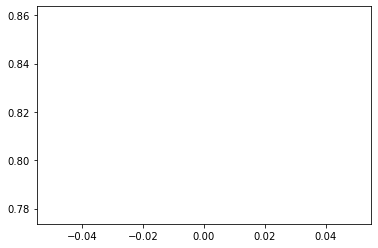

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4480, number of negative: 9020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16971
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 122
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331852 -> initscore=-0.699821
[LightGBM] [Info] Start training from score -0.699821
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.794794	valid_0's pr_auc: 0.751111
[4]	valid_0's auc: 0.807636	valid_0's pr_auc: 0.75932
[6]	valid_0's auc: 0.807851	valid_0's pr_auc: 0.760151
[8]	valid_0's auc: 0.808771	valid_0's pr_auc: 0.75938
[10]	valid_0's auc: 0.811768	valid_0's pr_auc: 0.755871
[12]	val

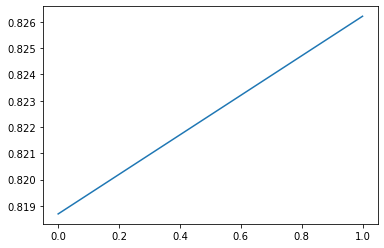

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4471, number of negative: 9029
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17014
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 122
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331185 -> initscore=-0.702830
[LightGBM] [Info] Start training from score -0.702830
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.799961	valid_0's pr_auc: 0.735115
[4]	valid_0's auc: 0.802689	valid_0's pr_auc: 0.735033
[6]	valid_0's auc: 0.808835	valid_0's pr_auc: 0.741481
[8]	valid_0's auc: 0.809317	valid_0's pr_auc: 0.747377
[10]	valid_0's auc: 0.810105	valid_0's pr_auc: 0.745604
[12]	v

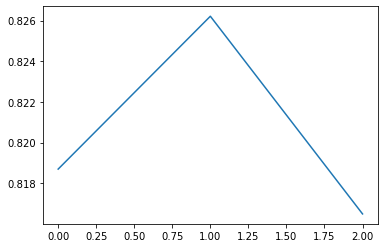

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4493, number of negative: 9007
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16997
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 122
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332815 -> initscore=-0.695481
[LightGBM] [Info] Start training from score -0.695481
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.794069	valid_0's pr_auc: 0.731223
[4]	valid_0's auc: 0.799421	valid_0's pr_auc: 0.733239
[6]	valid_0's auc: 0.804103	valid_0's pr_auc: 0.733055
[8]	valid_0's auc: 0.802632	valid_0's pr_auc: 0.731891
[10]	valid_0's auc: 0.80705	valid_0's pr_auc: 0.735053
[12]	va

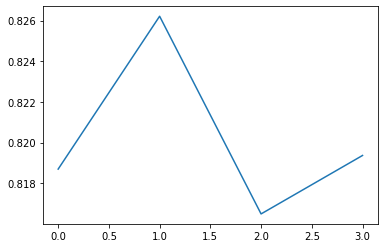

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4538, number of negative: 8962
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17036
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 122
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336148 -> initscore=-0.680507
[LightGBM] [Info] Start training from score -0.680507
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.819616	valid_0's pr_auc: 0.737985
[4]	valid_0's auc: 0.829397	valid_0's pr_auc: 0.747457
[6]	valid_0's auc: 0.833692	valid_0's pr_auc: 0.750504
[8]	valid_0's auc: 0.838269	valid_0's pr_auc: 0.753408
[10]	valid_0's auc: 0.841703	valid_0's pr_auc: 0.755166
[12]	v

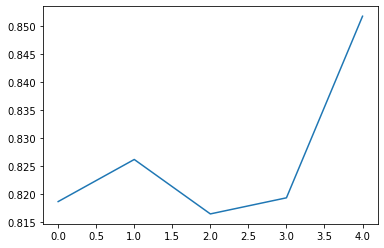

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4497, number of negative: 9003
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16980
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 122
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333111 -> initscore=-0.694147
[LightGBM] [Info] Start training from score -0.694147
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.802211	valid_0's pr_auc: 0.722517
[4]	valid_0's auc: 0.812915	valid_0's pr_auc: 0.728386
[6]	valid_0's auc: 0.815575	valid_0's pr_auc: 0.730383
[8]	valid_0's auc: 0.817048	valid_0's pr_auc: 0.741365
[10]	valid_0's auc: 0.817519	valid_0's pr_auc: 0.744656
[12]	v

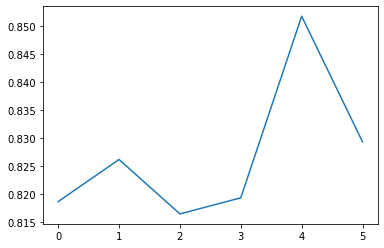

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4510, number of negative: 8990
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17015
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 122
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334074 -> initscore=-0.689816
[LightGBM] [Info] Start training from score -0.689816
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.809415	valid_0's pr_auc: 0.720582
[4]	valid_0's auc: 0.814624	valid_0's pr_auc: 0.713349
[6]	valid_0's auc: 0.82066	valid_0's pr_auc: 0.720122
[8]	valid_0's auc: 0.823367	valid_0's pr_auc: 0.718814
[10]	valid_0's auc: 0.823062	valid_0's pr_auc: 0.720556
[12]	va

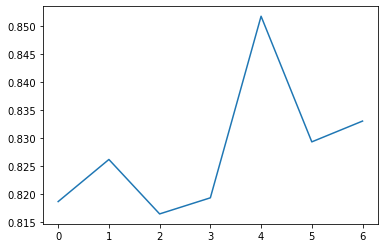

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4539, number of negative: 8961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16985
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 122
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336222 -> initscore=-0.680175
[LightGBM] [Info] Start training from score -0.680175
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.792297	valid_0's pr_auc: 0.680383
[4]	valid_0's auc: 0.802848	valid_0's pr_auc: 0.691725
[6]	valid_0's auc: 0.80728	valid_0's pr_auc: 0.696045
[8]	valid_0's auc: 0.807883	valid_0's pr_auc: 0.701656
[10]	valid_0's auc: 0.811622	valid_0's pr_auc: 0.702405
[12]	va

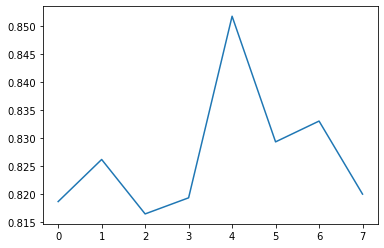

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4497, number of negative: 9003
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16982
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 122
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333111 -> initscore=-0.694147
[LightGBM] [Info] Start training from score -0.694147
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.806186	valid_0's pr_auc: 0.733976
[4]	valid_0's auc: 0.819348	valid_0's pr_auc: 0.742225
[6]	valid_0's auc: 0.827189	valid_0's pr_auc: 0.749748
[8]	valid_0's auc: 0.828236	valid_0's pr_auc: 0.755552
[10]	valid_0's auc: 0.82766	valid_0's pr_auc: 0.755529
[12]	va

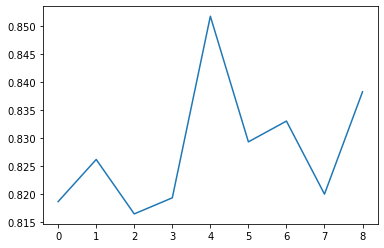

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4489, number of negative: 9011
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17020
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 122
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332519 -> initscore=-0.696816
[LightGBM] [Info] Start training from score -0.696816
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.775938	valid_0's pr_auc: 0.675377
[4]	valid_0's auc: 0.784141	valid_0's pr_auc: 0.685973
[6]	valid_0's auc: 0.788574	valid_0's pr_auc: 0.700121
[8]	valid_0's auc: 0.791837	valid_0's pr_auc: 0.706878
[10]	valid_0's auc: 0.795481	valid_0's pr_auc: 0.705441
[12]	v

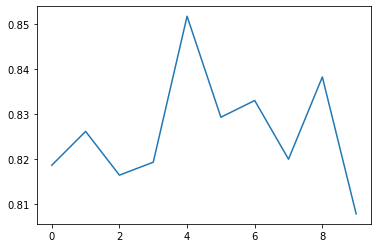

In [42]:
#train_x와 train_y로 나눔.
train_x = train.iloc[:,1:].values #dtype = ndarray
train_y = train_prob
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'learning_rate' : 0.1,
                
#                 'seed': 1015
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=10, shuffle=True)
#plot_importance할때 y축 columns. user_id빼고 columns추출.
columns = list(map(str,list(train.columns[1:])))

for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 3000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 2, 
                        early_stopping_rounds = 50,
                        feature_name = columns
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    print(valid_prob)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)
    plt.plot(auc_scores)
    plt.show()
    print('==========================================================')


# validation 평가

10
0.8517910317043265
0.8261210562716208
0.8078808181582535


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

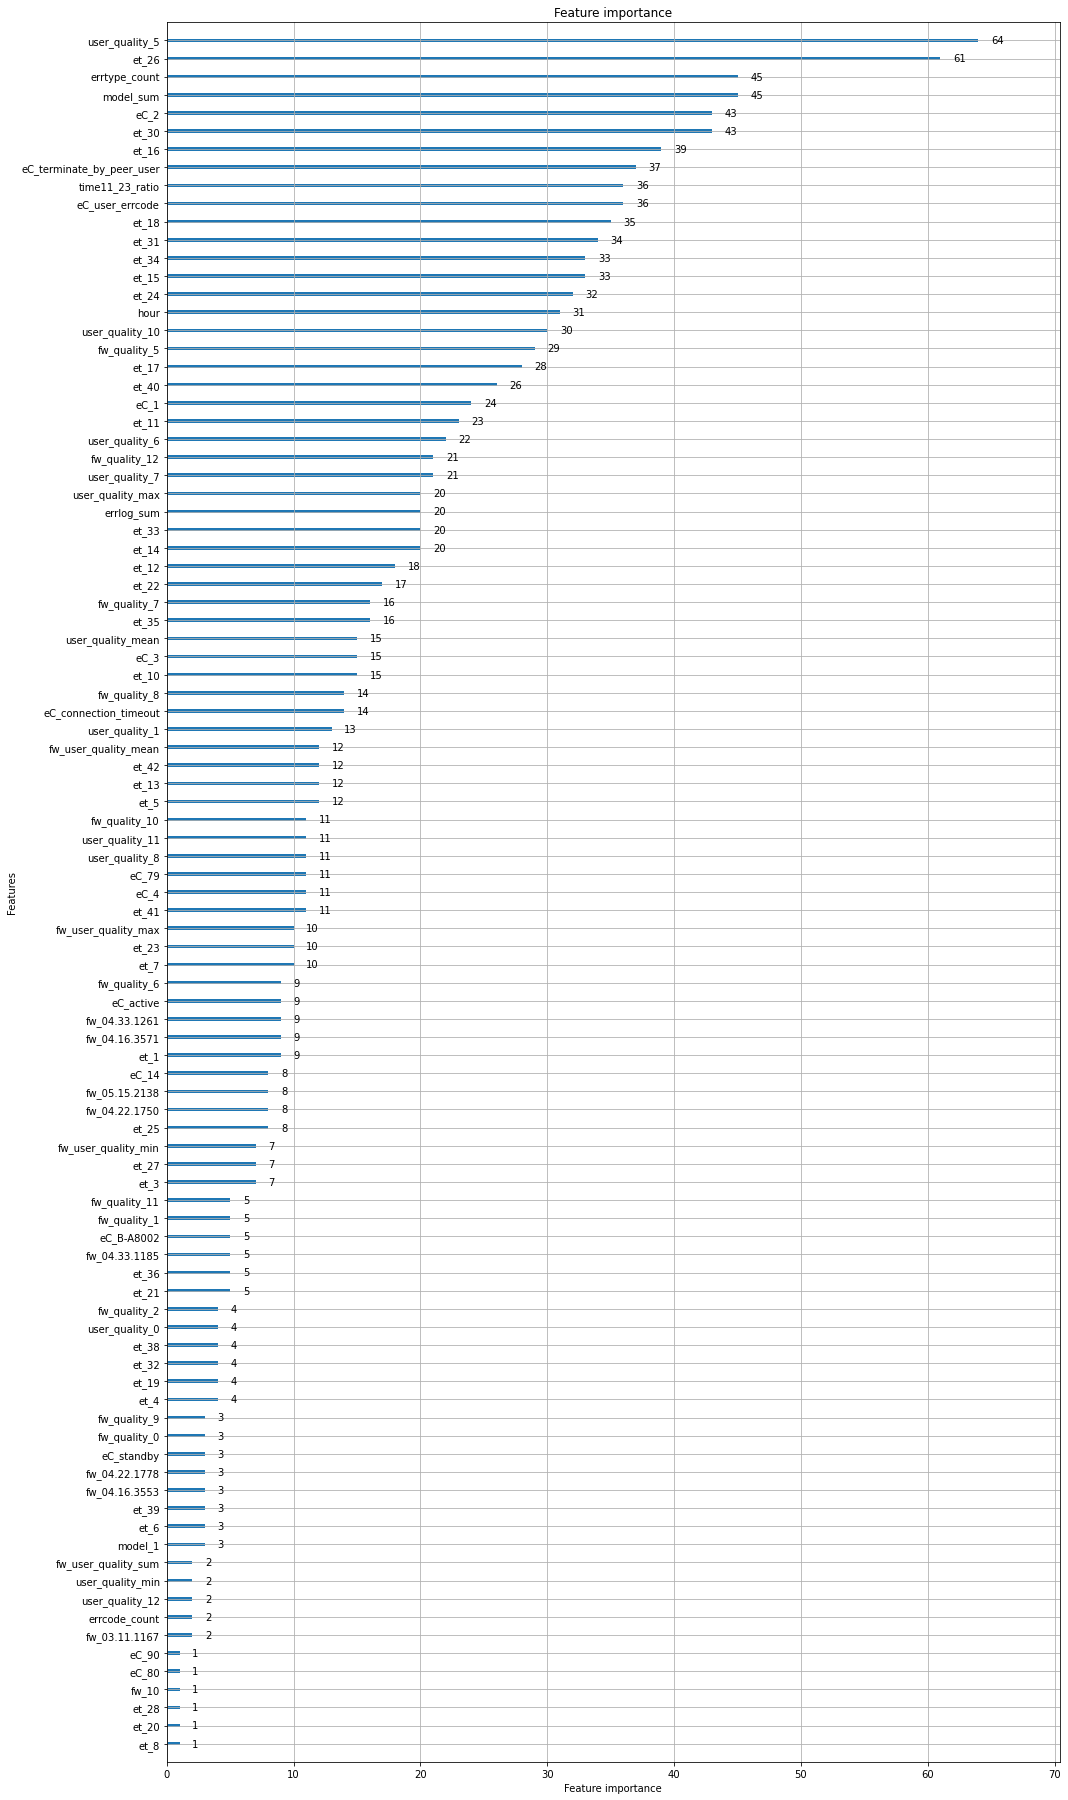

In [43]:

print(len(auc_scores))
print(np.max(auc_scores))
print(np.mean(auc_scores))
print(np.min(auc_scores))
from lightgbm import plot_importance

plot_importance(model, figsize=(16, 32))

In [44]:
# 이상치 채움
addrow = [43262]
for i in range(len(test.columns)-1):
    addrow.append(0)
test.loc[29998] = addrow
test = test.sort_values(by='user_id', ascending = True)

In [45]:
test_x = test.iloc[:,1:].values

# 예측
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)
sample_submission['problem'] = pred_ensemble.reshape(-1)
sample_submission.to_csv('0120_LGBM_binary.csv',index = False)
sample_submission

,user_id,problem
0,30000,0.936903
1,30001,0.228129
2,30002,0.550553
3,30003,0.641801
4,30004,0.886212
...,...,...
14994,44994,0.230563
14995,44995,0.348224
14996,44996,0.796329
14997,44997,0.881085
